<a href="https://colab.research.google.com/github/b-fatma/S2I-DM/blob/master/src/6_unsupervised/CLARANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=2c5eaa0d0b1db4a6066f4685256832c22d1c1e06f8b668787a1dbf5990eb7ae4
  Stored in directory: /root/.cache/pip/wheels/68/29/b4/131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


In [ ]:
# Install sklearn-extra
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=1959513 sha256=22e9016818be02de204c4944f69dbe94c5d1d3d18d9d463d704472257746d615
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [ ]:
# Downgrade NumPy to version 1.x for compatibility
!pip install "numpy<2.0"

# Restart the runtime after this

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score,adjusted_rand_score
from sklearn.decomposition import PCA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
y_train = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/y_test.csv')

X_test = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_test.csv')
X_train = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_train.csv')

X_test_scaled = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_test_scaled.csv')
X_train_scaled = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_train_scaled.csv')

In [ ]:
X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0)
X_scaled=X_scaled.values
y = pd.concat([y_train, y_test], axis=0)

## find optimal params

In [ ]:
# Use a smaller sample for parameter search
sample_size = 5000
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

print(f"Using sample of {sample_size} points for optimization\n")

# Test parameters on sample
k_range = [3, 4, 5, 6, 7]
results = []

for k in k_range:
    print(f"Testing k={k}...", end=' ')

    try:
        start = time.time()

        kmedoids = KMedoids(
            n_clusters=k,
            method='alternate',  # Faster method
            init='k-medoids++',
            max_iter=100,
            random_state=42
        )

        labels = kmedoids.fit_predict(X_sample)
        exec_time = time.time() - start

        silhouette = silhouette_score(X_sample, labels)

        results.append({
            'k': k,
            'silhouette': silhouette,
            'time': exec_time
        })

        print(f"Silhouette={silhouette:.4f}, Time={exec_time:.1f}s")

    except Exception as e:
        print(f"FAILED: {e}")

# Find best k
df_results = pd.DataFrame(results)
best = df_results.loc[df_results['silhouette'].idxmax()]

print(f"\n{'='*60}")
print("BEST PARAMETERS (from sample):")
print(f"{'='*60}")
print(f"k = {int(best['k'])}")
print(f"method = 'alternate'")
print(f"init = 'k-medoids++'")
print(f"Silhouette Score = {best['silhouette']:.4f}")



print(f"\n{'='*60}")
print("Recommended final configuration:")
print(f"{'='*60}")
print(f"""
kmedoids = KMedoids(
    n_clusters={int(best['k'])},
    method='alternate',
    init='k-medoids++',
    max_iter=100,
    random_state=42
)
""")

Using sample of 5000 points for optimization

Testing k=3... Silhouette=0.7691, Time=0.8s
Testing k=4... Silhouette=0.5980, Time=0.8s
Testing k=5... Silhouette=0.5486, Time=0.8s
Testing k=6... Silhouette=0.5534, Time=0.8s
Testing k=7... Silhouette=0.5064, Time=0.8s

BEST PARAMETERS (from sample):
k = 3
method = 'alternate'
init = 'k-medoids++'
Silhouette Score = 0.7691

Recommended final configuration:

kmedoids = KMedoids(
    n_clusters=3,
    method='alternate',
    init='k-medoids++',
    max_iter=100,
    random_state=42
)



## predefined CLARANS (KMedoid)


In [ ]:
print("Running KMedoids with BATCH PROCESSING")
print(f"{'='*60}\n")

k_opt = 3  # From your optimization

# Step 1: Find medoids on sample
print("Step 1: Finding medoids on sample...")
sample_size = 5000
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

start_time = time.time()

kmedoids = KMedoids(
    n_clusters=k_opt,
    method='alternate',
    init='k-medoids++',
    max_iter=100,
    random_state=42
)

kmedoids.fit(X_sample)

medoid_indices_in_sample = kmedoids.medoid_indices_
actual_medoid_indices = sample_indices[medoid_indices_in_sample]
medoids = X_scaled[actual_medoid_indices]

print(f"✓ Medoids found in {time.time() - start_time:.1f}s")

# Step 2: Assign all points in batches
print(f"\nStep 2: Assigning all {len(X_scaled)} points in batches...")

labels = np.zeros(len(X_scaled), dtype=int)
batch_size = 5000

for i in range(0, len(X_scaled), batch_size):
    end_i = min(i + batch_size, len(X_scaled))
    batch = X_scaled[i:end_i]

    distances = np.sqrt(np.sum((batch[:, np.newaxis, :] - medoids[np.newaxis, :, :]) ** 2, axis=2))
    labels[i:end_i] = np.argmin(distances, axis=1)

    print(f"  Progress: {end_i}/{len(X_scaled)} ({end_i/len(X_scaled)*100:.1f}%)", end='\r')

execution_time = time.time() - start_time
print(f"\n✓ Completed in {execution_time:.1f}s ({execution_time/60:.1f} min)")

# ============================================
# Calculate Metrics
# ============================================

print(f"\n{'='*60}")
print("CALCULATING METRICS")
print(f"{'='*60}\n")

# Metrics on sample
eval_size = 5000
eval_indices = np.random.choice(len(X_scaled), eval_size, replace=False)
X_eval = X_scaled[eval_indices]
labels_eval = labels[eval_indices]

silhouette_final = silhouette_score(X_eval, labels_eval)
davies_bouldin_final = davies_bouldin_score(X_eval, labels_eval)
calinski_final = calinski_harabasz_score(X_eval, labels_eval)

print(f"\n{'='*60}")
print("FINAL RESULTS")
print(f"{'='*60}")
print(f"Number of Clusters: {k_opt}")
print(f"Execution Time: {execution_time:.2f}s ({execution_time/60:.1f} min)")
print(f"\nMetrics (on {eval_size} sample):")
print(f"  Silhouette Score: {silhouette_final:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_final:.4f}")
print(f"  Calinski-Harabasz Score: {calinski_final:.2f}")

# Cluster distribution
unique, counts = np.unique(labels, return_counts=True)
print(f"\nCluster Distribution:")
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(labels)*100:.2f}%)")

print(f"\n✅ DONE! Results are in 'labels' variable")

Running KMedoids with BATCH PROCESSING

Step 1: Finding medoids on sample...
✓ Medoids found in 1.8s

Step 2: Assigning all 55219 points in batches...
  Progress: 55219/55219 (100.0%)
✓ Completed in 1.9s (0.0 min)

CALCULATING METRICS


FINAL RESULTS
Number of Clusters: 3
Execution Time: 1.95s (0.0 min)

Metrics (on 5000 sample):
  Silhouette Score: 0.7730
  Davies-Bouldin Index: 0.4253
  Calinski-Harabasz Score: 41568.25

Cluster Distribution:
  Cluster 0: 44051 samples (79.78%)
  Cluster 1: 5940 samples (10.76%)
  Cluster 2: 5228 samples (9.47%)

✅ DONE! Results are in 'labels' variable


## CLARANS Analysis

In [ ]:
# Calculate metrics
silhouette_avg = silhouette_score(X_scaled, labels)
davies_bouldin = davies_bouldin_score(X_scaled, labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, labels)

print(f"\nSilhouette Score: {silhouette_avg:.4f}")
print(f"  → Range: [-1, 1], Higher is better")
print(f"  → Interpretation: {'Excellent' if silhouette_avg > 0.7 else 'Good' if silhouette_avg > 0.5 else 'Moderate' if silhouette_avg > 0.25 else 'Poor'}")

print(f"\nDavies-Bouldin Index: {davies_bouldin:.4f}")
print(f"  → Lower is better (well-separated clusters)")

print(f"\nCalinski-Harabasz Score: {calinski_harabasz:.2f}")
print(f"  → Higher is better (dense, well-separated clusters)")


Silhouette Score: 0.7760
  → Range: [-1, 1], Higher is better
  → Interpretation: Excellent

Davies-Bouldin Index: 0.4223
  → Lower is better (well-separated clusters)

Calinski-Harabasz Score: 453173.28
  → Higher is better (dense, well-separated clusters)


In [ ]:
# 2. CLUSTER SIZE DISTRIBUTION
# ============================================================================
print("\n" + "="*70)
print("CLUSTER SIZE DISTRIBUTION")
print("="*70)

unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

for cluster_id, size in cluster_sizes.items():
    percentage = (size / len(labels)) * 100
    print(f"Cluster {cluster_id}: {size:,} points ({percentage:.2f}%)")

# Check for imbalance
max_size = max(counts)
min_size = min(counts)
imbalance_ratio = max_size / min_size
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 5:
    print("  ⚠️ Warning: Significant cluster size imbalance detected")


CLUSTER SIZE DISTRIBUTION
Cluster 0: 44,051 points (79.78%)
Cluster 1: 5,940 points (10.76%)
Cluster 2: 5,228 points (9.47%)

Imbalance Ratio: 8.43
  ⚠️ Warning: Significant cluster size imbalance detected



GENERATING VISUALIZATIONS

1. PCA 2D projection...
2. Silhouette analysis...
3. Distance distribution...
4. 3D PCA projection...
5. Cluster compactness metrics...


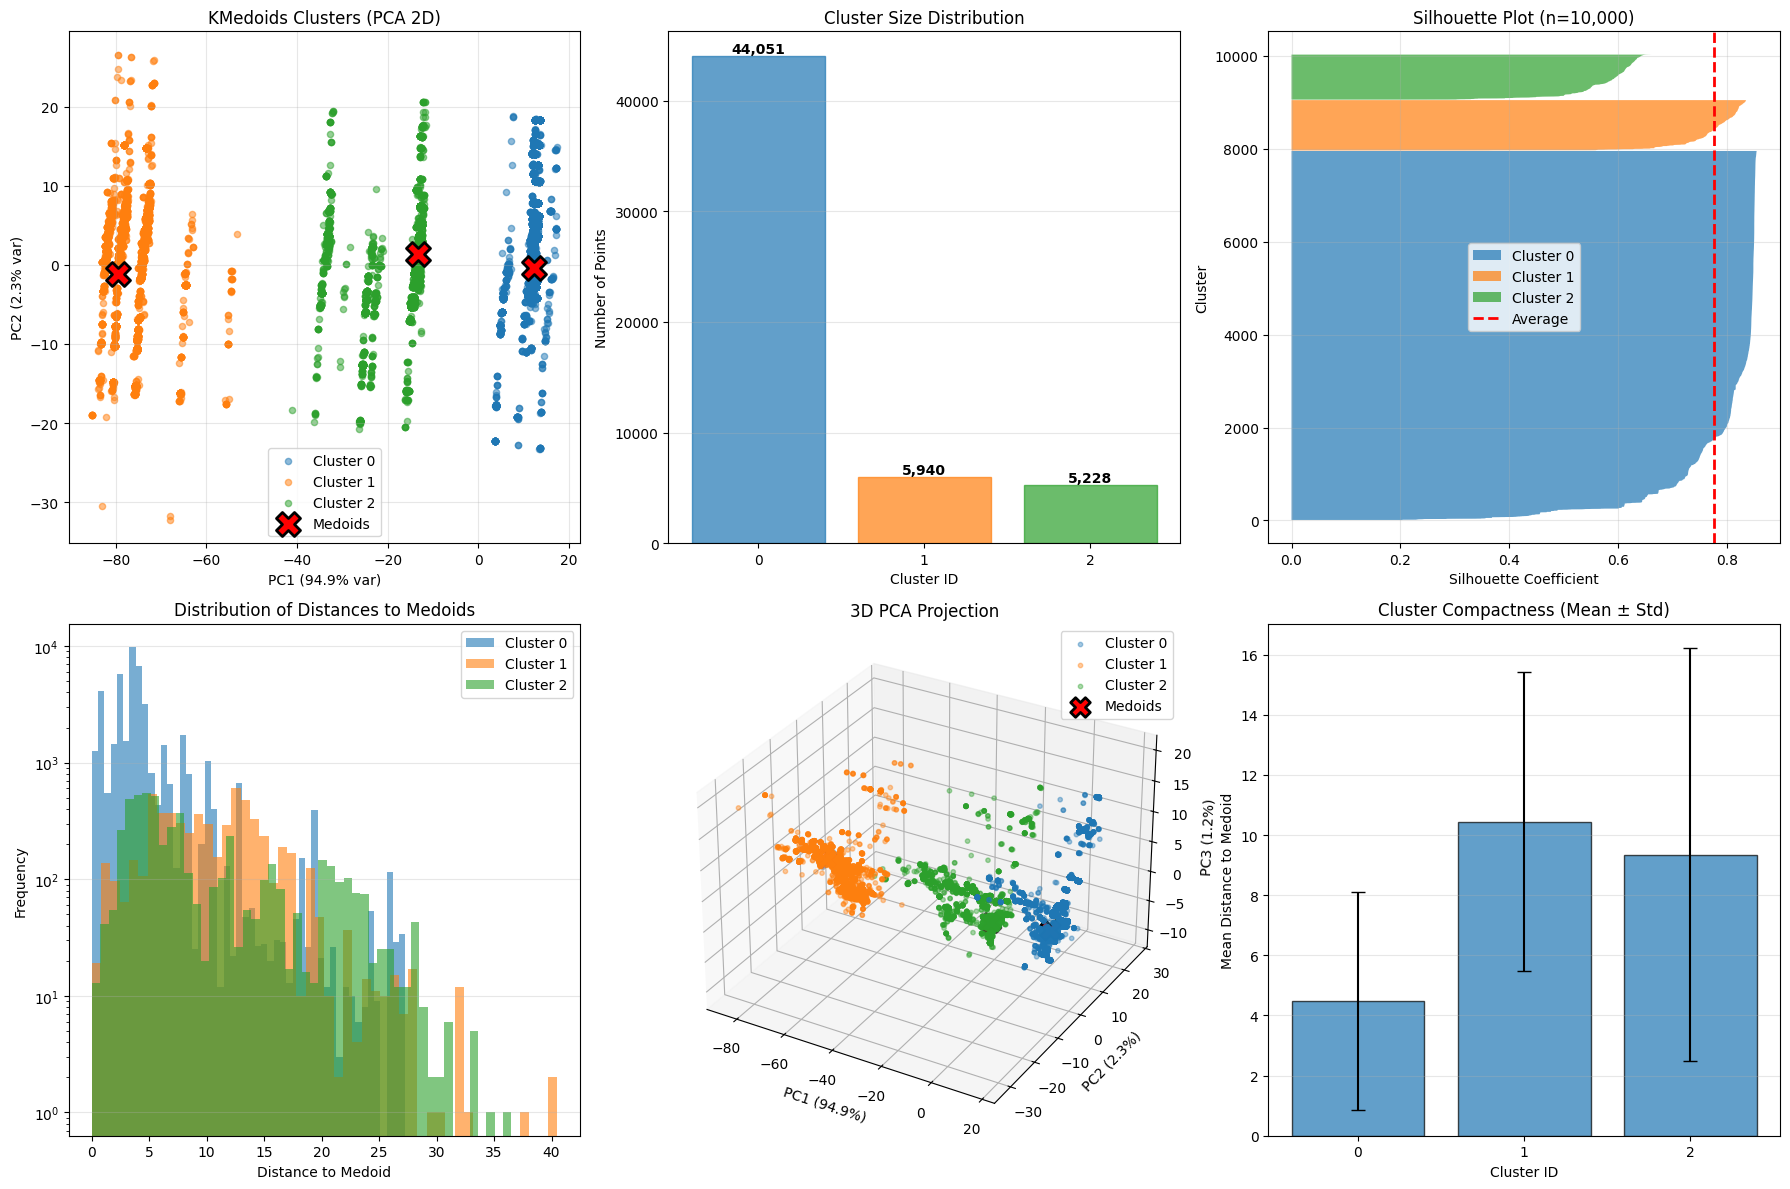

In [ ]:
# 3. VISUALIZATIONS
# ============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(18, 12))

# 3.1: PCA Visualization
print("\n1. PCA 2D projection...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
medoids_pca = pca.transform(medoids)

ax1 = plt.subplot(2, 3, 1)
for i in range(k_opt):
    mask = labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], alpha=0.5, s=20, label=f'Cluster {i}')
plt.scatter(medoids_pca[:, 0], medoids_pca[:, 1],
           c='red', marker='X', s=300, edgecolors='black', linewidths=2,
           label='Medoids', zorder=5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
plt.title('KMedoids Clusters (PCA 2D)')
plt.legend()
plt.grid(True, alpha=0.3)

# 3.2: Cluster Size Bar Plot
ax2 = plt.subplot(2, 3, 2)
bars = plt.bar(cluster_sizes.keys(), cluster_sizes.values(), alpha=0.7, edgecolor='black')
for i, (cluster_id, size) in enumerate(cluster_sizes.items()):
    bars[i].set_color(plt.cm.tab10(i))
plt.xlabel('Cluster ID')
plt.ylabel('Number of Points')
plt.title('Cluster Size Distribution')
plt.xticks(list(cluster_sizes.keys()))
for i, (k, v) in enumerate(cluster_sizes.items()):
    plt.text(k, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 3.3: Silhouette Analysis (sample for speed)
print("2. Silhouette analysis...")
from sklearn.metrics import silhouette_samples

sample_size_viz = min(10000, len(X_scaled))
sample_idx = np.random.choice(len(X_scaled), sample_size_viz, replace=False)
silhouette_vals = silhouette_samples(X_scaled[sample_idx], labels[sample_idx])

ax3 = plt.subplot(2, 3, 3)
y_lower = 10
for i in range(k_opt):
    cluster_silhouette_vals = silhouette_vals[labels[sample_idx] == i]
    cluster_silhouette_vals.sort()

    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                      alpha=0.7, label=f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label='Average')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.title(f'Silhouette Plot (n={sample_size_viz:,})')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# 3.4: Distance to Medoid Distribution
print("3. Distance distribution...")
distances_to_medoid = np.zeros(len(X_scaled))
for i in range(len(X_scaled)):
    cluster_id = labels[i]
    distances_to_medoid[i] = np.linalg.norm(X_scaled[i] - medoids[cluster_id])

ax4 = plt.subplot(2, 3, 4)
for i in range(k_opt):
    mask = labels == i
    plt.hist(distances_to_medoid[mask], bins=50, alpha=0.6, label=f'Cluster {i}')
plt.xlabel('Distance to Medoid')
plt.ylabel('Frequency')
plt.title('Distribution of Distances to Medoids')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.yscale('log')

# 3.5: 3D PCA Visualization
print("4. 3D PCA projection...")
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)
medoids_pca_3d = pca_3d.transform(medoids)

ax5 = plt.subplot(2, 3, 5, projection='3d')
for i in range(k_opt):
    mask = labels == i
    ax5.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
               alpha=0.4, s=10, label=f'Cluster {i}')
ax5.scatter(medoids_pca_3d[:, 0], medoids_pca_3d[:, 1], medoids_pca_3d[:, 2],
           c='red', marker='X', s=200, edgecolors='black', linewidths=2,
           label='Medoids')
ax5.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax5.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax5.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax5.set_title('3D PCA Projection')
ax5.legend()

# 3.6: Cluster Compactness
print("5. Cluster compactness metrics...")
ax6 = plt.subplot(2, 3, 6)

cluster_stats = []
for i in range(k_opt):
    mask = labels == i
    dists = distances_to_medoid[mask]
    cluster_stats.append({
        'mean': dists.mean(),
        'std': dists.std(),
        'median': np.median(dists)
    })

x_pos = np.arange(k_opt)
means = [s['mean'] for s in cluster_stats]
stds = [s['std'] for s in cluster_stats]

plt.bar(x_pos, means, yerr=stds, alpha=0.7, capsize=5, edgecolor='black')
plt.xlabel('Cluster ID')
plt.ylabel('Mean Distance to Medoid')
plt.title('Cluster Compactness (Mean ± Std)')
plt.xticks(x_pos)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
analysis_df = pd.DataFrame({
    'cluster': labels,
    'fire': y.squeeze()

})
for cluster_id in sorted(np.unique(labels)):
    cluster_data = analysis_df[analysis_df['cluster'] == cluster_id]

    total_in_cluster = len(cluster_data)
    fire_count = np.sum(cluster_data['fire'] == 1)  # Assuming 1 = fire, 0 = no fire
    no_fire_count = total_in_cluster - fire_count

    fire_percentage = (fire_count / total_in_cluster) * 100

    print(f"Cluster {cluster_id}:")
    print(f"  Total samples: {total_in_cluster}")
    print(f"  Fire instances: {fire_count} ({fire_percentage:.2f}%)")
    print(f"  No-fire instances: {no_fire_count} ({100-fire_percentage:.2f}%)")
    print()

Cluster 0:
  Total samples: 44051
  Fire instances: 10498 (23.83%)
  No-fire instances: 33553 (76.17%)

Cluster 1:
  Total samples: 5940
  Fire instances: 1610 (27.10%)
  No-fire instances: 4330 (72.90%)

Cluster 2:
  Total samples: 5228
  Fire instances: 635 (12.15%)
  No-fire instances: 4593 (87.85%)



## from scratch

In [ ]:
class CLARANS:
    def __init__(self, n_clusters=5, numlocal=2, maxneighbor=250, random_state=42):
        """
        CLARANS clustering implementation from scratch

        CLARANS = Clustering Large Applications based on RANdomized Search

        Parameters:
        -----------
        n_clusters : int, number of clusters (k)
        numlocal : int, number of local minima to find
        maxneighbor : int, maximum number of neighbors to examine
        random_state : int, random seed for reproducibility
        """
        self.n_clusters = n_clusters
        self.numlocal = numlocal
        self.maxneighbor = maxneighbor
        self.random_state = random_state
        self.medoids_ = None
        self.labels_ = None
        self.cost_ = None
        self.best_cost_ = float('inf')

    def _compute_distance(self, point1, point2):
        """Compute Euclidean distance between two points"""
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _compute_distances_to_medoids(self, X, medoid_indices):
        """
        Compute distances from all points to current medoids
        Returns: (n_samples, n_clusters) distance matrix
        """
        medoids = X[medoid_indices]
        # Vectorized distance computation
        distances = np.sqrt(np.sum((X[:, np.newaxis, :] - medoids[np.newaxis, :, :]) ** 2, axis=2))
        return distances

    def _assign_clusters(self, distances):
        """Assign each point to nearest medoid"""
        return np.argmin(distances, axis=1)

    def _compute_cost(self, X, medoid_indices):
        """
        Compute total cost (sum of distances to nearest medoid)
        This is the objective function CLARANS minimizes
        """
        distances = self._compute_distances_to_medoids(X, medoid_indices)
        min_distances = np.min(distances, axis=1)
        return np.sum(min_distances)

    def _get_random_neighbor(self, current_medoids, n_samples):
        """
        Generate a random neighbor configuration
        A neighbor differs by exactly one medoid
        """
        # Copy current medoids
        neighbor = current_medoids.copy()

        # Randomly select which medoid to replace
        medoid_to_replace = np.random.randint(0, self.n_clusters)

        # Select a random non-medoid point
        non_medoids = np.setdiff1d(np.arange(n_samples), current_medoids)
        new_medoid = np.random.choice(non_medoids)

        # Replace the medoid
        neighbor[medoid_to_replace] = new_medoid

        return neighbor

    def _search_local_minimum(self, X, initial_medoids):
        """
        Search for a local minimum starting from initial medoids
        This is the core CLARANS algorithm
        """
        n_samples = X.shape[0]
        current_medoids = initial_medoids.copy()
        current_cost = self._compute_cost(X, current_medoids)

        # Search for better neighbors
        for _ in range(self.maxneighbor):
            # Generate random neighbor
            neighbor_medoids = self._get_random_neighbor(current_medoids, n_samples)
            neighbor_cost = self._compute_cost(X, neighbor_medoids)

            # If neighbor is better, move to it and restart search
            if neighbor_cost < current_cost:
                current_medoids = neighbor_medoids
                current_cost = neighbor_cost
                # Restart the neighbor search counter (implicit by continuing loop)

        return current_medoids, current_cost

    def fit(self, X):
        """
        Fit CLARANS to data

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]

        print(f"Starting CLARANS with {self.n_clusters} clusters")
        print(f"Data shape: {X.shape}")
        print(f"Parameters: numlocal={self.numlocal}, maxneighbor={self.maxneighbor}")

        best_medoids = None
        best_cost = float('inf')

        # Try to find numlocal local minima
        print(f"\nSearching for {self.numlocal} local minima...")

        for local_search in tqdm(range(self.numlocal), desc="Local searches"):
            # Randomly initialize medoids
            initial_medoids = np.random.choice(n_samples, self.n_clusters, replace=False)

            # Search for local minimum
            local_medoids, local_cost = self._search_local_minimum(X, initial_medoids)

            # Keep track of best solution found
            if local_cost < best_cost:
                best_cost = local_cost
                best_medoids = local_medoids
                print(f"\n  → New best cost: {best_cost:.2f}")

        # Store best solution
        self.medoids_ = best_medoids
        self.best_cost_ = best_cost

        # Compute final cluster assignments
        distances = self._compute_distances_to_medoids(X, self.medoids_)
        self.labels_ = self._assign_clusters(distances)
        self.cost_ = best_cost

        print(f"\n{'='*60}")
        print(f"CLARANS completed!")
        print(f"Final cost: {self.cost_:.2f}")
        print(f"Medoid indices: {self.medoids_}")
        print(f"{'='*60}")

        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        distances = self._compute_distances_to_medoids(X, self.medoids_)
        return self._assign_clusters(distances)

    def fit_predict(self, X):
        """Fit and return cluster labels"""
        self.fit(X)
        return self.labels_

In [ ]:
print(f"\n{'='*60}")
print("Running CLARANS (Custom Implementation)")
print(f"{'='*60}\n")

# Use same k as KMedoids for fair comparison
k_opt = 3
numlocal_opt = 2
maxneighbor_opt = 250

print(f"Parameters:")
print(f"  n_clusters = {k_opt}")
print(f"  numlocal = {numlocal_opt}")
print(f"  maxneighbor = {maxneighbor_opt}")
print(f"\nRunning on all {len(X_scaled)} samples...")
print("This may take 10-20 minutes...\n")

start_time = time.time()

# Run your custom CLARANS
clarans = CLARANS(
    n_clusters=k_opt,
    numlocal=numlocal_opt,
    maxneighbor=maxneighbor_opt,
    random_state=42
)

labels_clarans = clarans.fit_predict(X_scaled)

execution_time_costum = time.time() - start_time

print(f"✓ CLARANS completed in {execution_time_costum:.1f}s ({execution_time/60:.1f} min)")

# ============================================
# Calculate Metrics
# ============================================

print(f"\n{'='*60}")
print("CALCULATING METRICS")
print(f"{'='*60}\n")

# Metrics on sample (same size as KMedoids for fair comparison)
eval_size = 5000
np.random.seed(42)
eval_indices = np.random.choice(len(X_scaled), eval_size, replace=False)
X_eval = X_scaled[eval_indices]
labels_eval = labels_clarans[eval_indices]

silhouette_clarans = silhouette_score(X_eval, labels_eval)
davies_bouldin_clarans = davies_bouldin_score(X_eval, labels_eval)
calinski_clarans = calinski_harabasz_score(X_eval, labels_eval)

print(f"\n{'='*60}")
print("FINAL RESULTS - CLARANS (Custom)")
print(f"{'='*60}")
print(f"Number of Clusters: {k_opt}")
print(f"Total Cost: {clarans.cost_:.2f}")
print(f"Execution Time: {execution_time:.2f}s ({execution_time/60:.1f} min)")
print(f"\nMetrics (on {eval_size} sample):")
print(f"  Silhouette Score: {silhouette_clarans:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_clarans:.4f}")
print(f"  Calinski-Harabasz Score: {calinski_clarans:.2f}")


Running CLARANS (Custom Implementation)

Parameters:
  n_clusters = 3
  numlocal = 2
  maxneighbor = 250

Running on all 55219 samples...
This may take 10-20 minutes...

Starting CLARANS with 3 clusters
Data shape: (55219, 26)
Parameters: numlocal=2, maxneighbor=250

Searching for 2 local minima...


Local searches:  50%|█████     | 1/2 [00:05<00:05,  5.54s/it]


  → New best cost: 313219.02


Local searches: 100%|██████████| 2/2 [00:10<00:00,  5.38s/it]



CLARANS completed!
Final cost: 313219.02
Medoid indices: [ 3207 23004 46548]
✓ CLARANS completed in 10.8s (0.0 min)

CALCULATING METRICS


FINAL RESULTS - CLARANS (Custom)
Number of Clusters: 3
Total Cost: 313219.02
Execution Time: 0.73s (0.0 min)

Metrics (on 5000 sample):
  Silhouette Score: 0.7691
  Davies-Bouldin Index: 0.4165
  Calinski-Harabasz Score: 39642.33


In [ ]:
unique_c, counts_c = np.unique(labels_clarans, return_counts=True)
clarans_sizes = dict(zip(unique_c, counts_c))

## Comparative analysis

In [ ]:
# Agreement between the two clusterings
ari_agreement = adjusted_rand_score(labels, labels_clarans)
# Create comparison dataframe
metrics_comparison = pd.DataFrame({
    'KMedoids': [silhouette_avg, davies_bouldin, calinski_harabasz, execution_time],
    'CLARANS': [silhouette_clarans, davies_bouldin_clarans, calinski_clarans, execution_time_costum]
}, index=['Silhouette Score ↑', 'Davies-Bouldin ↓', 'Calinski-Harabasz ↑', 'Time (seconds)'])



In [ ]:
ari_custom = adjusted_rand_score(y.squeeze(), labels)
ari_custom

-0.018896162603769556

In [ ]:
print(ari_agreement)

1.0


In [ ]:
metrics_comparison

,KMedoids,CLARANS
Silhouette Score ↑,0.776013,0.769147
Davies-Bouldin ↓,0.422251,0.416480
Calinski-Harabasz ↑,453173.275318,39642.328447
Time (seconds),0.727924,10.791150


In [ ]:
medoid_indices_clarans = clarans.medoids_
medoids_clarans = X_scaled[medoid_indices_clarans]
labels_clarans = clarans.labels_
cost_clarans = clarans.cost_


GENERATING COMPARATIVE VISUALIZATIONS


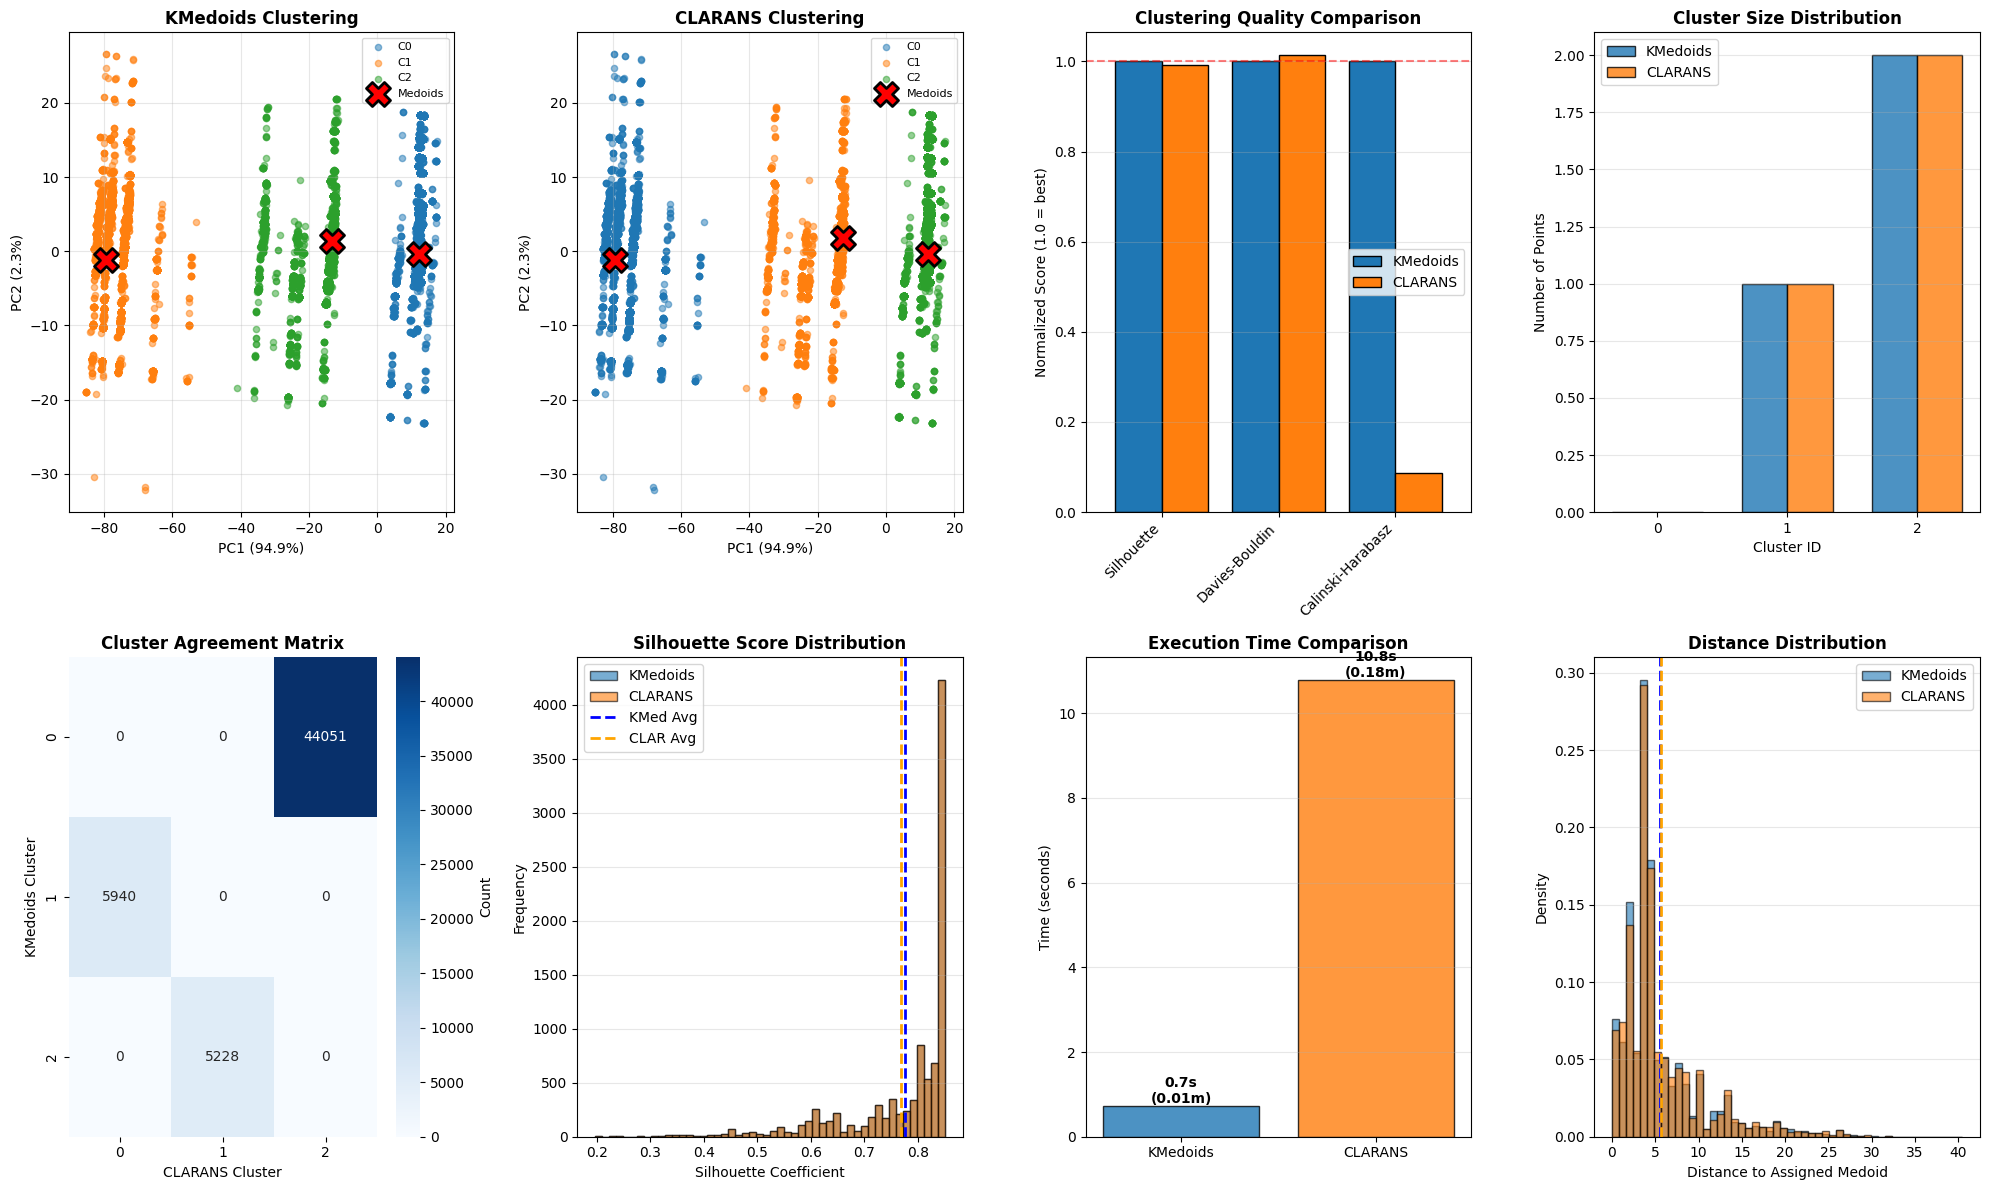


STATISTICAL COMPARISON

Average Distance to Medoid:
  KMedoids: 5.5812 (±4.7379)
  CLARANS:  5.6723 (±4.8389)

Cluster Compactness (within-cluster variance):
  KMedoids: 53.5968
  CLARANS:  55.5901


In [ ]:
# 4. VISUALIZATIONS
# ============================================================================
print("\n" + "="*70)
print("GENERATING COMPARATIVE VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(20, 12))

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
kmedoids_medoids_pca = pca.transform(medoids)
clarans_medoids_pca = pca.transform(medoids_clarans)

# 4.1: KMedoids Clustering
ax1 = plt.subplot(2, 4, 1)
for i in range(k_opt):
    mask = labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], alpha=0.5, s=20, label=f'C{i}')
plt.scatter(kmedoids_medoids_pca[:, 0], kmedoids_medoids_pca[:, 1],
           c='red', marker='X', s=300, edgecolors='black', linewidths=2,
           label='Medoids', zorder=5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('KMedoids Clustering', fontweight='bold', fontsize=12)
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

# 4.2: CLARANS Clustering
ax2 = plt.subplot(2, 4, 2)
for i in range(k_opt):
    mask = labels_clarans == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], alpha=0.5, s=20, label=f'C{i}')
plt.scatter(clarans_medoids_pca[:, 0], clarans_medoids_pca[:, 1],
           c='red', marker='X', s=300, edgecolors='black', linewidths=2,
           label='Medoids', zorder=5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('CLARANS Clustering', fontweight='bold', fontsize=12)
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

# 4.3: Metrics Comparison Bar Plot
ax3 = plt.subplot(2, 4, 3)
metrics_normalized = pd.DataFrame({
    'KMedoids': [
       silhouette_avg / max(silhouette_avg, silhouette_clarans),
        davies_bouldin_clarans / davies_bouldin if davies_bouldin < davies_bouldin_clarans else 1.0,  # Lower is better
        calinski_harabasz / max(calinski_harabasz,  calinski_clarans)
    ],
    'CLARANS': [
        silhouette_clarans / max(silhouette_avg, silhouette_clarans),
        davies_bouldin / davies_bouldin_clarans if davies_bouldin_clarans < davies_bouldin else 1.0,  # Lower is better
         calinski_clarans / max(calinski_harabasz,  calinski_clarans)
    ]
}, index=['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'])

metrics_normalized.plot(kind='bar', ax=ax3, width=0.8, edgecolor='black')
ax3.set_ylabel('Normalized Score (1.0 = best)')
ax3.set_title('Clustering Quality Comparison', fontweight='bold', fontsize=12)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Best')

# 4.4: Cluster Size Comparison
ax4 = plt.subplot(2, 4, 4)
x = np.arange(k_opt)
width = 0.35
bars1 = ax4.bar(x - width/2, cluster_sizes, width, label='KMedoids', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x + width/2, clarans_sizes, width, label='CLARANS', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Cluster ID')
ax4.set_ylabel('Number of Points')
ax4.set_title('Cluster Size Distribution', fontweight='bold', fontsize=12)
ax4.set_xticks(x)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 4.5: Agreement Matrix (Confusion Matrix)
ax5 = plt.subplot(2, 4, 5)
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(labels, labels_clarans)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax5,
            cbar_kws={'label': 'Count'})
ax5.set_xlabel('CLARANS Cluster')
ax5.set_ylabel('KMedoids Cluster')
ax5.set_title('Cluster Agreement Matrix', fontweight='bold', fontsize=12)

# 4.6: Silhouette Scores Distribution
from sklearn.metrics import silhouette_samples

sample_size_viz = min(10000, len(X_scaled))
sample_idx = np.random.choice(len(X_scaled), sample_size_viz, replace=False)

kmedoids_silhouette_samples = silhouette_samples(X_scaled[sample_idx], labels[sample_idx])
clarans_silhouette_samples = silhouette_samples(X_scaled[sample_idx], labels_clarans[sample_idx])

ax6 = plt.subplot(2, 4, 6)
ax6.hist(kmedoids_silhouette_samples, bins=50, alpha=0.6, label='KMedoids', edgecolor='black')
ax6.hist(clarans_silhouette_samples, bins=50, alpha=0.6, label='CLARANS', edgecolor='black')
ax6.axvline(silhouette_avg, color='blue', linestyle='--', linewidth=2, label='KMed Avg')
ax6.axvline(silhouette_clarans, color='orange', linestyle='--', linewidth=2, label='CLAR Avg')
ax6.set_xlabel('Silhouette Coefficient')
ax6.set_ylabel('Frequency')
ax6.set_title('Silhouette Score Distribution', fontweight='bold', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# 4.7: Execution Time Comparison
ax7 = plt.subplot(2, 4, 7)
times = [execution_time, execution_time_costum]
colors = ['#1f77b4', '#ff7f0e']
bars = ax7.bar(['KMedoids', 'CLARANS'], times, color=colors, alpha=0.8, edgecolor='black')
ax7.set_ylabel('Time (seconds)')
ax7.set_title('Execution Time Comparison', fontweight='bold', fontsize=12)
for i, (bar, t) in enumerate(zip(bars, times)):
    ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{t:.1f}s\n({t/60:.2f}m)', ha='center', va='bottom', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

# 4.8: Distance to Medoid Comparison
ax8 = plt.subplot(2, 4, 8)

# Calculate distances to medoids
kmedoids_distances = np.zeros(len(X_scaled))
clarans_distances = np.zeros(len(X_scaled))

for i in range(len(X_scaled)):
    kmedoids_cluster = labels[i]
    clarans_cluster = labels_clarans[i]

    kmedoids_distances[i] = np.linalg.norm(X_scaled[i] - medoids[kmedoids_cluster])
    clarans_distances[i] = np.linalg.norm(X_scaled[i] - medoids_clarans[clarans_cluster])

ax8.hist(kmedoids_distances, bins=50, alpha=0.6, label='KMedoids', density=True, edgecolor='black')
ax8.hist(clarans_distances, bins=50, alpha=0.6, label='CLARANS', density=True, edgecolor='black')
ax8.axvline(np.mean(kmedoids_distances), color='blue', linestyle='--', linewidth=2)
ax8.axvline(np.mean(clarans_distances), color='orange', linestyle='--', linewidth=2)
ax8.set_xlabel('Distance to Assigned Medoid')
ax8.set_ylabel('Density')
ax8.set_title('Distance Distribution', fontweight='bold', fontsize=12)
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# 5. STATISTICAL COMPARISON
# ============================================================================
print("\n" + "="*70)
print("STATISTICAL COMPARISON")
print("="*70)

print("\nAverage Distance to Medoid:")
print(f"  KMedoids: {np.mean(kmedoids_distances):.4f} (±{np.std(kmedoids_distances):.4f})")
print(f"  CLARANS:  {np.mean(clarans_distances):.4f} (±{np.std(clarans_distances):.4f})")

print("\nCluster Compactness (within-cluster variance):")
kmedoids_compactness = np.mean(kmedoids_distances**2)
clarans_compactness = np.mean(clarans_distances**2)
print(f"  KMedoids: {kmedoids_compactness:.4f}")
print(f"  CLARANS:  {clarans_compactness:.4f}")